# Volatility Forecasting: GARCH

## ARCH AND GARCH

### ARCH: Autoregressive conditional heteroskedasticity
The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model

### GARCH: Generalised Autoregressive conditional heteroskedasticity 
The GARCH model is appropriate when the error variance in a timer series follows an autoregressive moving average (ARMA) model

ARCH/GARCH models are commonly employed in modeling financial time series that exhibit time varying volatility and volatility clustering

### Defintions

### ARCH(q)
Consider a return time series
$$r_{t} = \mu + \epsilon_{t}$$
Where $\mu$ is some expected return and $\epsilon$ denotes the error terms.

Then we claim that we can specify
$$\epsilon_{t} = \sigma_{t} z_{t}$$
Where $z_{t}$ is a strong white noise process, and $\sigma_{t}$ is the time dependent standard deviation

Thus, the series $\sigma_{t}^{2}$ can modeled by
$$\sigma_{t}^{2} = a_{0}+a_{1}\epsilon_{t-1}^{2}+...+a_{q}\epsilon_{t-q}^{2}=a_{0}+\Sigma_{i=1}^{q}a_{i}\epsilon^{2}_{t-i}$$

Then of course, an ARCH(q) model can be estimated using ordinary least squares. A lagrange multiplier test can be used to see if we need an ARMA model

### GARCH(q,p)
In similar fashion to how ARMA models are definded, $\sigma_{t}$ is modelled as, where q is order of ARCH terms, and p is order of the GARCH terms,

$$\sigma_{t}^{2} = \omega +\Sigma_{i=1}^{q}a_{i}\epsilon^{2}_{t-i} + \Sigma_{i=1}^{p}b_{i}\sigma^{2}_{t-i}$$

### Paramters
We should note that all the parameters all $>0$ and in the case of GARCH, if the sum of parameters is $<1$, the model is mean reverting to the long run variance given by
$$\frac{\omega}{1-a-b}$$



In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas_datareader import data as pdr

import yfinance as yfin
yfin.pdr_override()

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import scipy.stats as stats

from arch import arch_model
from pylab import rcParams 

from arch.__future__ import reindexing
reindexing = True

D:\PythonUOW\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Simulating ARCH(1) and GARCH(1,1) Series
Since we can nest an ARCH model inside a GARCH one, can easily define a single function
$$\sigma_{t}^{2} = \omega + a_{1}\epsilon^{2}_{t-1} + b_{1}\sigma^{2}_{t-1}$$


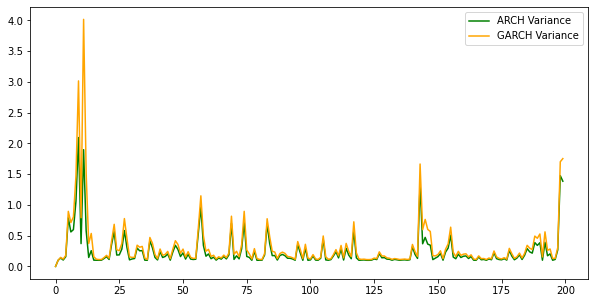

In [2]:

def simulate_GARCH(n, omega, alpha, beta = 0): #default is ARCH, hence beta = 0
    np.random.seed(6)
    
    # Initialize the parameters
    # will require _like as without "maximum supported dimension for an ndarray is 32, found 200"
    #  is recieved
    white_noise = np.random.normal(size = n) # will require _like as 
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

 # ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'green', label = 'ARCH Variance')

# Plot GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()


## ARCH Package For GARCH Modeling
We can use the ARCh python package to implement GARCH models


[*********************100%%**********************]  1 of 1 completed


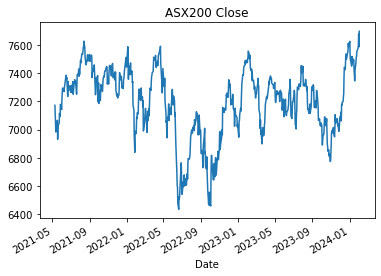

In [3]:
#Setting some arbitrary time period

end = dt.datetime.now()
start =end - dt.timedelta(days=1000)

# Importing some stock data
df = pdr.get_data_yahoo('^AXJO', start, end)

#print(df.head())


adjusted_close = df['Close']
adjusted_close.plot()
plt.title('ASX200 Close')
plt.show()


In [4]:
### Calculating returns
df['return'] = 100*(df['Close'].pct_change())

df['lnReturn']  =np.log(df['Close']/df['Close'].shift(1)).dropna()
df = df.dropna()

# Daily SD of returns
sd_daily = df['return'].std()

# Daily to Monthly vol
sd_monthly = np.sqrt(21) * sd_daily

# daily to annual
sd_annual = np.sqrt(252) * sd_daily

print(f'Daily volatility: {round(sd_daily,2)}%')
print(f'\nMonthly volatility: {round(sd_monthly,2)}%')
print(f'\nAnnual volatility: {round(sd_annual,2)}%')

Daily volatility: 0.83%

Monthly volatility: 3.8%

Annual volatility: 13.15%


## Basic GARCH(1,1) Model
The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

In [5]:
# Specify GARCH model assumptions
basic_gm = arch_model(df['return'])
# Fit the model
gm_result = basic_gm.fit(update_freq = 0)

# Display model fitting summary
print(gm_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 828.3205778524829
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -828.321
Distribution:                  Normal   AIC:                           1664.64
Method:            Maximum Likelihood   BIC:                           1682.80
                                        No. Observations:                  692
Date:                Sat, Feb 03 2024   Df Residuals:                      691
Time:                        16:14:57   Df Model:                            1
                                  Mean Model                                 
  

### Model Summary
Important summary satistics to look for

R-Squared: proportion of variance in a dependent variable that can be predicted or explained by an independent variable. Our GARCH(1,1) model gave 0, which is unsurprising considering this an extremely basic model

P>|t|: The significance of the parameters. Since the P-values are all <<0.05 significance level, they are all deemed significant (So yes, we definitely should not remove any paramaters, except for the mu parameter)

AIC / BIC / Log-Likelihood: These are important for when comparing models



### Distribution Assumptions
The ARCH package allows us to make distributional assumptions out of normal for the residuals and returns.

Financial time series data does not often follow a normal distribution perfectly. While it can be shown that returns, like that from stocks, follow random walks and roughly follow a normal dsitribution, which is a decent assumption, more often then not, distributions in reality have much fatter tails and skewness not from a normal dsitribution.



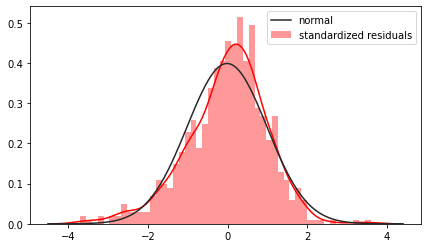

In [6]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

### GARCH(1,1) with a Students t-distribution

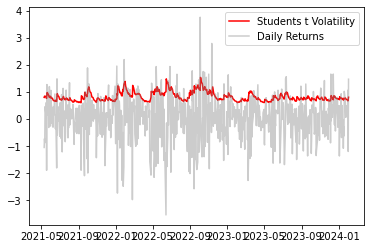

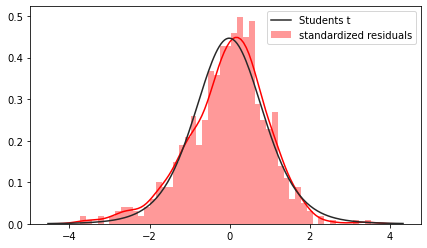

In [7]:
# Specify GARCH model assumptions
t_gm = arch_model(df['return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'studentst')

# Fit the model
t_result = t_gm.fit(disp = 'off')

# Get model estimated volatility
t_vol = t_result.conditional_volatility

# Plot model fitting results
plt.plot(t_vol, color = 'red', label = 'Students t Volatility')
plt.plot(df['return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()


# Obtain model estimated residuals and volatility
t_resid = t_result.resid
t_std = t_result.conditional_volatility

# Calculate the standardized residuals
t_std_resid = t_resid /t_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(t_std_resid, norm_hist=True, fit=stats.t, bins=50, color='r')
plt.legend(('Students t', 'standardized residuals'))
plt.show()

The students t distrubution has a much better fit for the residuals. This is because the students t distribution can better account for fatter tails, though it is still not accounting for the skewness in the standardized residuals

### Model Mean Specifications
Constant mean: 'generally' works ok with most financial return data.

Autoregressive mean: model the mean as an autoregressive (AR) process.

Zero mean: Use when the mean has been modeled separately to fit the residuals of the separate model to estimate volatility (preferred method).


### Making Forecasts
call .forecast() to make a prediction. By default it produces a 1-step ahead estimate. You can use horizon = n to specify longer forward periods.

Any call to forecast() returns a ARCHModelForecast object with has 3 core attributes

mean - The forecast conditional mean.

variance - The forecast conditional variance.

residual_variance - The forecast conditional variance of residuals. This will differ from variance whenever the model has dynamics (e.g. an AR model) for horizons larger than 1.

All models support three methods of forecasting:

#### Analytical: 
analytical forecasts are always available for the 1-step ahead forecast due to the structure of ARCH-type models. Multi-step analytical forecasts are only available for model which are linear in the square of the residual, such as GARCH or HARCH.

#### Simulation: 
simulation-based forecasts are always available for any horizon, although they are only useful for horizons larger than 1 since the first out-of-sample forecast from an ARCH-type model is always fixed. Simulation-based forecasts make use of the structure of an ARCH-type model to forward simulate using the assumed distribution of residuals, e.g., a Normal or Student’s t.

#### Bootstrap: 
bootstrap-based forecasts are similar to simulation based forecasts except that they make use of the standardized residuals from the actual data used in the estimation rather than assuming a specific distribution. Like simulation-base forecasts, bootstrap-based forecasts are only useful for horizons larger than 1. Additionally, the bootstrap forecasting method requires a minimal amount of in-sample data to use prior to producing the forecasts.


In [8]:
# Make 5-period ahead forecast
t_forecast = t_result.forecast(horizon = 5)

# Print the forecast variance
print(t_forecast.variance[-1:])

#converting all the columns into 1

df_vol = t_forecast.variance.stack().reset_index()
df_vol.rename( columns={0 :'var'}, inplace=True )

print(df_vol)

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2024-02-02  0.779672  0.774951  0.770555  0.766462  0.762651
        Date level_1       var
0 2024-02-02     h.1  0.779672
1 2024-02-02     h.2  0.774951
2 2024-02-02     h.3  0.770555
3 2024-02-02     h.4  0.766462
4 2024-02-02     h.5  0.762651


## Modeling Asymmetric Responses of Volatility: Shocks and Leverage Effect

GARCH models assume that positive and negative news has a symmetric impact on volatility. However, in reality this is not the case.

#### Leverage Effect
reflects a phenomenon commonly referred to as the "leverage effect", signifying that negative returns increase future volatility by a larger amount than positive returns of the same magnitude. This is what is term as asymmetric impacts, negative news tends to affect the volatility more than positive news.

### Models

#### GJR-GARCH
Suppose $\epsilon_{t} =\sigma_{t} z_{t}$, then claim
$$\sigma^{2}_{t}=\omega +a\sigma^{2}_{t-1} + b\epsilon^{2}_{t-1}+c\epsilon^{2}_{t-1}I_{t-1}$$
where, if $\epsilon_{t-1}\geq 0$
$$I_{t-1}=0$$
or if $\epsilon_{t-1}\leq 0$
$$I_{t-1}=1$$


#### Exponential GARCH
$$log(\sigma^{2}_{t})=\omega \Sigma_{k=1}^{q}b_{k}g(Z_{t-k})+\Sigma_{k=1}^{p}a_{k}log(\sigma^{2}_{t-k})$$
Where,
$$g(Z_{t})=\theta Z_{t}+\lambda (|Z_{t}-E(|Z_{t}|)$$

The formulation for $g(Z_{t})$ allows the sign and the magnitude of $Z_{t}$ to have separate effects on volatility.

And since $log(\sigma^{2}_{t})$ may be negative, there are so restrictions on the sign of the parameters.





In [10]:

# Specify GJR-GARCH model 
gjr_gm = arch_model(df['return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')


# Specify EGARCH model 
egarch_gm = arch_model(df['return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')




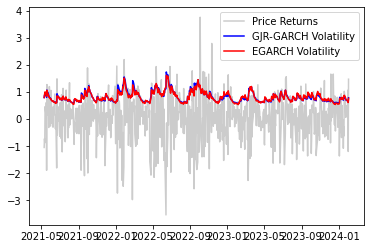

In [11]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the ASX200 returns
plt.plot(df['return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [16]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'EGARCH BIC: {egarch_result.bic}')

# Print each models AIC
print(f'\nGJR-GARCH AIC: {gjrgm_result.aic}')
print(f'EGARCH AIC: {egarch_result.aic}')

GJR-GARCH BIC: 1665.691395119812
EGARCH BIC: 1665.8753409667177

GJR-GARCH AIC: 1638.4538793861059
EGARCH AIC: 1638.6378252330117


## Backtesting: MAE and MSE

MAE (Mean Absolute Error) is the average of all absolute errors. The absolute average distance between the real data and the predicted data, but cannot punish large errors in prediction. It avoids mutual cancellation of the positive and negative errors.

MSE, measures the average of the squares of the errors. The average squared difference between the estimated values and the actual value. Due to the square, large errors are emphasized and have a relatively greater effect on the the performance metric. The effect of relatively small errors will be even smaller.


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
def evaluate(observation, forecast): 
    
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
   
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

In [22]:
# call evaluate function

evaluate(df['return'].sub(df['return'].mean()).pow(2), egarch_vol**2)



Mean Absolute Error (MAE): 0.693
Mean Squared Error (MSE): 1.494


(0.6931405728262001, 1.4943570390122767)

## Fixed Rolling Window

We use a continuously moving sample to forecast with. That is, at every pass we supply new data points while old ones are dropped from the sample

This allows the forecast/model to avoid lookback bias and adapt the forecasts to new observations, which in total leads to less overfitting.

However, a too wide window size will include obsolete data and lead to higher bias. A too narrow window will exclude relevant data and lead to higher variance

The optimal window size will always have to trade off against these two isssues.




## Simulations and Bootstrap Forecasts

In [49]:
# The paths for the final observation
sim_forecasts = egarch_result.forecast(horizon=10, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = egarch_result.forecast(horizon=10, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

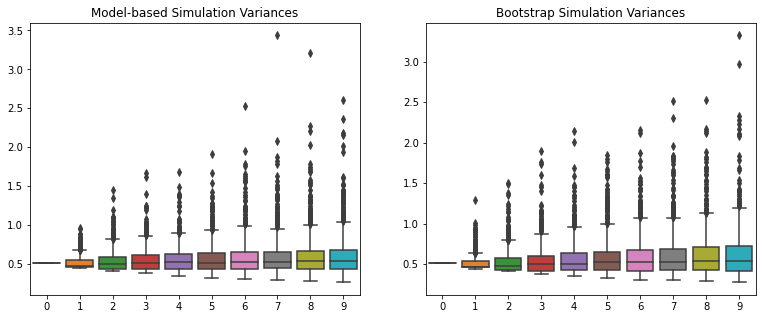

In [50]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()